In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

%cd ../..

!hostname

/p/fastdata/pli/Private/oberstrass1/datasets/vervet1818-3d
jrlogin08.jureca


In [2]:
import os

import re
import pandas as pd
import numpy as np

import pli
import pli.image as im

from tqdm import tqdm

In [12]:
# Load section infos

model_name = "resnet18_sphere"

feature_path = f"data/aa/features/"
mask_path = "data/aa/masks/cortex/"

# Group of the mask in the H5 files
mask_group = 'Image'

# Group of the features in the H5 files
data_group = 'Features/512'

###

import h5py as h5

feature_folder = os.path.join(feature_path, model_name)

p = re.compile('.*s([0-9]{4})_.*')

feature_list = []
for f in sorted(os.listdir(feature_folder)):
    id = int(p.match(f)[1])
    with h5.File(os.path.join(feature_folder, f)) as h5f:
        spacing = h5f[data_group].attrs['spacing']
        origin = h5f[data_group].attrs['origin'] if 'origin' in h5f[data_group].attrs.keys() else (0, 0)
    feature_list.append({'id': id, 'spacing': spacing, 'origin': origin, 'file_feature': os.path.join(feature_folder, f)})
feature_df = pd.DataFrame(feature_list).sort_values('id').reset_index(drop=True)

mask_list = []
for f in sorted(os.listdir(mask_path)):
    id = int(p.match(f)[1])
    mask_list.append({'id': id, 'file_mask': os.path.join(mask_path, f)})
mask_df = pd.DataFrame(mask_list).sort_values('id').reset_index(drop=True)

files_df = mask_df.merge(feature_df, on='id', how='left')

files_df.head()

,id,file_mask,spacing,origin,file_feature
0,841,data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...,"[84.37760174274445, 84.37760174274445]","[0.0, 0.0]",data/aa/features/resnet18_sphere/Vervet1818aa_...
1,842,data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...,"[84.37760174274445, 84.37760174274445]","[0.0, 0.0]",data/aa/features/resnet18_sphere/Vervet1818aa_...
2,843,data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...,"[84.37760174274445, 84.37760174274445]","[0.0, 0.0]",data/aa/features/resnet18_sphere/Vervet1818aa_...
3,844,data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...,"[84.37760174274445, 84.37760174274445]","[0.0, 0.0]",data/aa/features/resnet18_sphere/Vervet1818aa_...
4,845,data/aa/masks/cortex/Vervet1818aa_60mu_70ms_s0...,"[84.37760174274445, 84.37760174274445]","[0.0, 0.0]",data/aa/features/resnet18_sphere/Vervet1818aa_...


In [4]:
# Fit PCA by subsample of the data

# Number of randomly selected sections
n_subsamples = 32  # len(files_df)

# Coressponding pyramid to the Feature size
mask_pyramid = 6

seed = 299792458

# Masking of features to include foreground only
mask_features = True
background_class = 3

###

from vervet1818_3d.utils.io import read_masked_features

np.random.seed(seed)

selected_features = []
selected_masks = []

section_ids = []

for k, r in tqdm(files_df.sample(n_subsamples).sort_values('id').iterrows(), total=n_subsamples):
    features, mask = read_masked_features(
        r.file_feature,
        r.file_mask,
        mask_pyramid=mask_pyramid,
        data_group=data_group,
        mask_group=mask_group
    )
    assert features.shape[:2] == mask.shape, f"{features.shape[:2]} differs from {mask.shape}"

    selected_features.append(features)
    selected_masks.append(mask)
    section_ids.append(r.id)

print(f"Use sections {section_ids}")

if mask_features:
    valid_features = [f[m != background_class] for f, m in zip(selected_features, selected_masks)]
else:
    valid_features = [sf.reshape(-1, sf.shape[-1]) for sf in selected_features]

valid_lengths = [len(vf) for vf in valid_features]
valid_features = np.vstack(valid_features)
del selected_features

print(f"Valid features have shape {valid_features.shape}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:16<00:00,  1.94it/s]


Use sections [869, 871, 873, 875, 877, 881, 890, 898, 901, 919, 923, 931, 946, 947, 952, 959, 963, 975, 989, 993, 996, 997, 999, 1030, 1045, 1047, 1050, 1051, 1053, 1062, 1071, 1078]
Valid features have shape (2216493, 512)


In [5]:
# Perform PCA

n_samples = 100_000

seed = 299792458

###

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.random.seed(seed)

ix = np.random.choice(np.arange(len(valid_features)), n_samples)
pca_components = len(valid_features[0])

scaler = StandardScaler()
std_features = scaler.fit_transform(valid_features[ix])

pca = PCA(n_components=pca_components, whiten=False)
pca.fit(std_features)

PCA(n_components=512)

Optimum found at 11 components


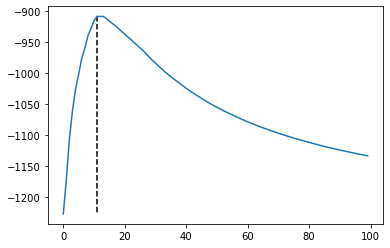

In [6]:
# Get optimal number of components

import matplotlib.pyplot as plt

from vervet1818_3d.utils.stats import profile_likelihood

pl = np.array([profile_likelihood(l, pca) for l in range(pca.n_components)])

pl_components = np.argmax(pl)
print(f"Optimum found at {pl_components} components")

plt.vlines(np.argmax(pl), pl.max(), pl.min(), colors='black', linestyles='--')
plt.plot(pl[:100]);

Explained variance: 50.08% with 24 components


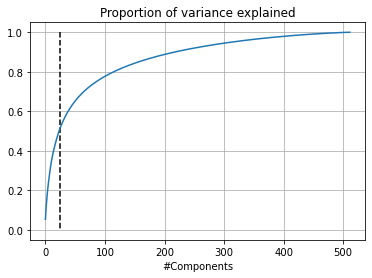

In [22]:
# Function of variance explained

min_variance_explained = 0.5

###

import matplotlib.pyplot as plt

scree = np.cumsum(pca.explained_variance_)
scree /= scree[-1]

variance_components = np.argwhere(scree > min_variance_explained)[0, 0] + 1

n_components = max(pl_components, variance_components)

variance_explained = scree[n_components -1] / scree[-1]

print(f"Explained variance: {100 * variance_explained:.2f}% with {n_components} components")
plt.plot(scree)
plt.vlines(n_components, scree.max(), 0, colors='black', linestyles='--')
plt.title("Proportion of variance explained")
plt.xlabel("#Components")
plt.grid()
plt.show()

In [23]:
out_folder = "data/aa/pca/"
pca_key = "PCA"
valid_key = "Valid"

###

from vervet1818_3d.utils.stats import pca_n_transform

import h5py as h5

out_path = os.path.join(out_folder, model_name)

if not os.path.exists(out_path):
    os.mkdir(out_path)

for k, r in tqdm(files_df.iterrows(), total=len(files_df)):

    test_features, test_mask = read_masked_features(
        r.file_feature,
        r.file_mask,
        mask_pyramid=mask_pyramid,
        data_group=data_group,
        mask_group=mask_group
    )

    test_valid = test_mask != background_class
    test_std = scaler.transform(test_features.reshape(-1, test_features.shape[-1]))

    test_pca = pca_n_transform(test_std, pca, n_components)
    test_pca = test_pca.reshape(*test_features.shape[:2], test_pca.shape[-1])

    out_file = os.path.basename(r.file_feature).replace('Features', 'PCA')
    with h5.File(os.path.join(out_path, out_file), 'w') as f:
        pca_dset = f.create_dataset(pca_key, data=test_pca.transpose(2, 0, 1), dtype=np.float32)
        pca_dset.attrs['spacing'] = r.spacing
        pca_dset.attrs['origin'] = r.origin
        pca_dset.attrs['variance_explained'] = variance_explained
        pca_dset.attrs['n_components'] = n_components
        pca_dset.attrs['pl_components'] = pl_components

        valid_dset = f.create_dataset(valid_key, data=test_valid)
        valid_dset.attrs['spacing'] = r.spacing
        valid_dset.attrs['origin'] = r.origin

  0%|▍                                                                                                      | 1/232 [00:03<13:30,  3.51s/it]


KeyboardInterrupt: 

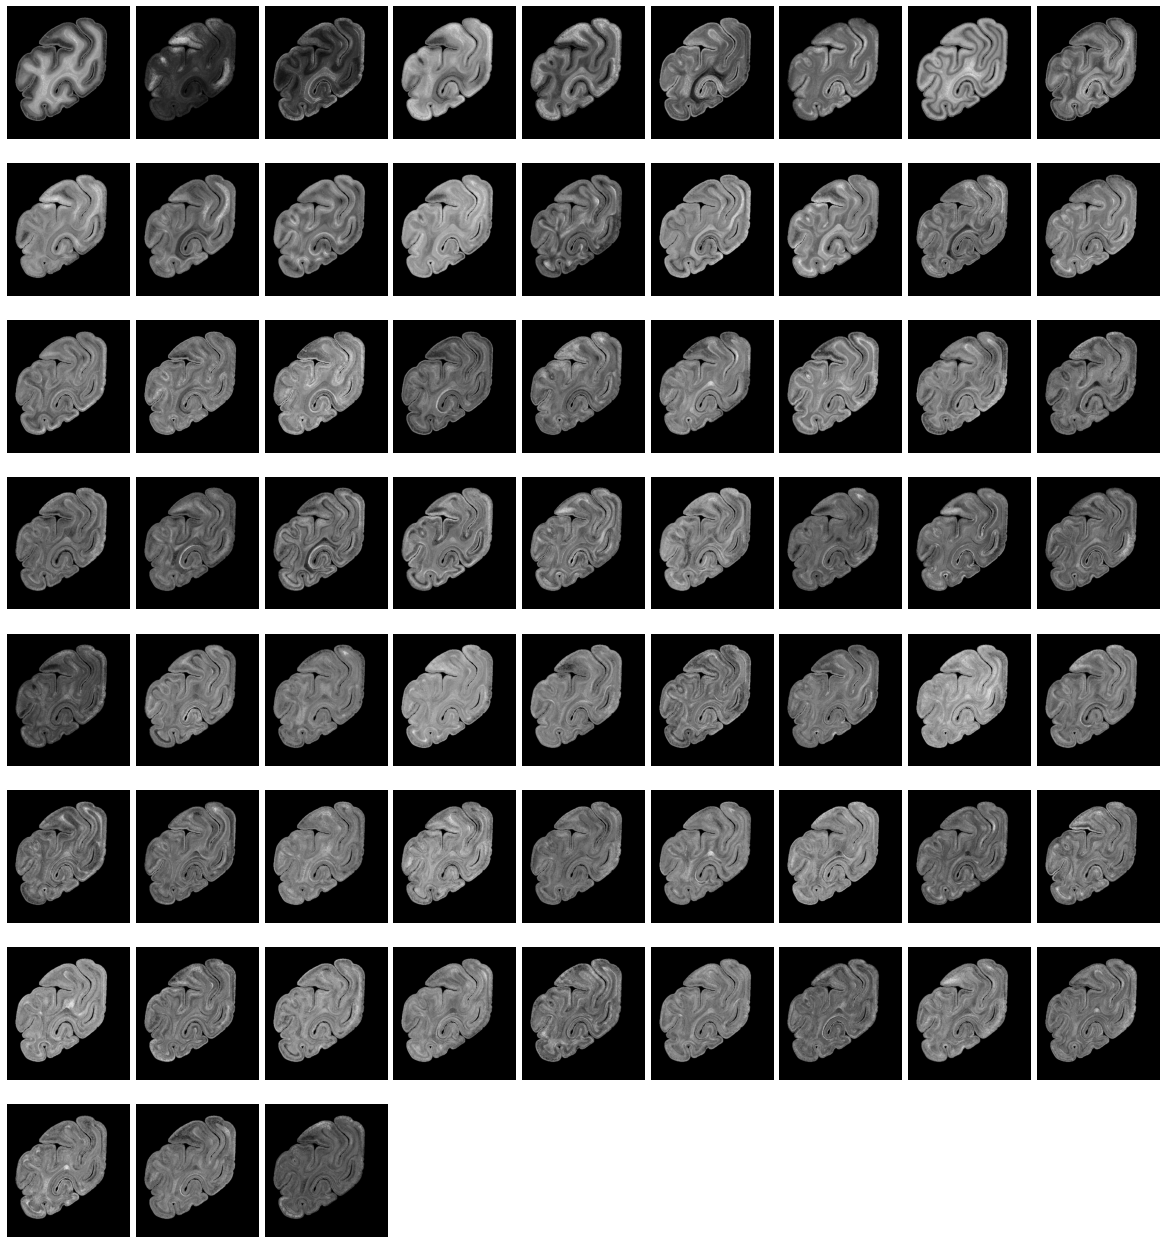

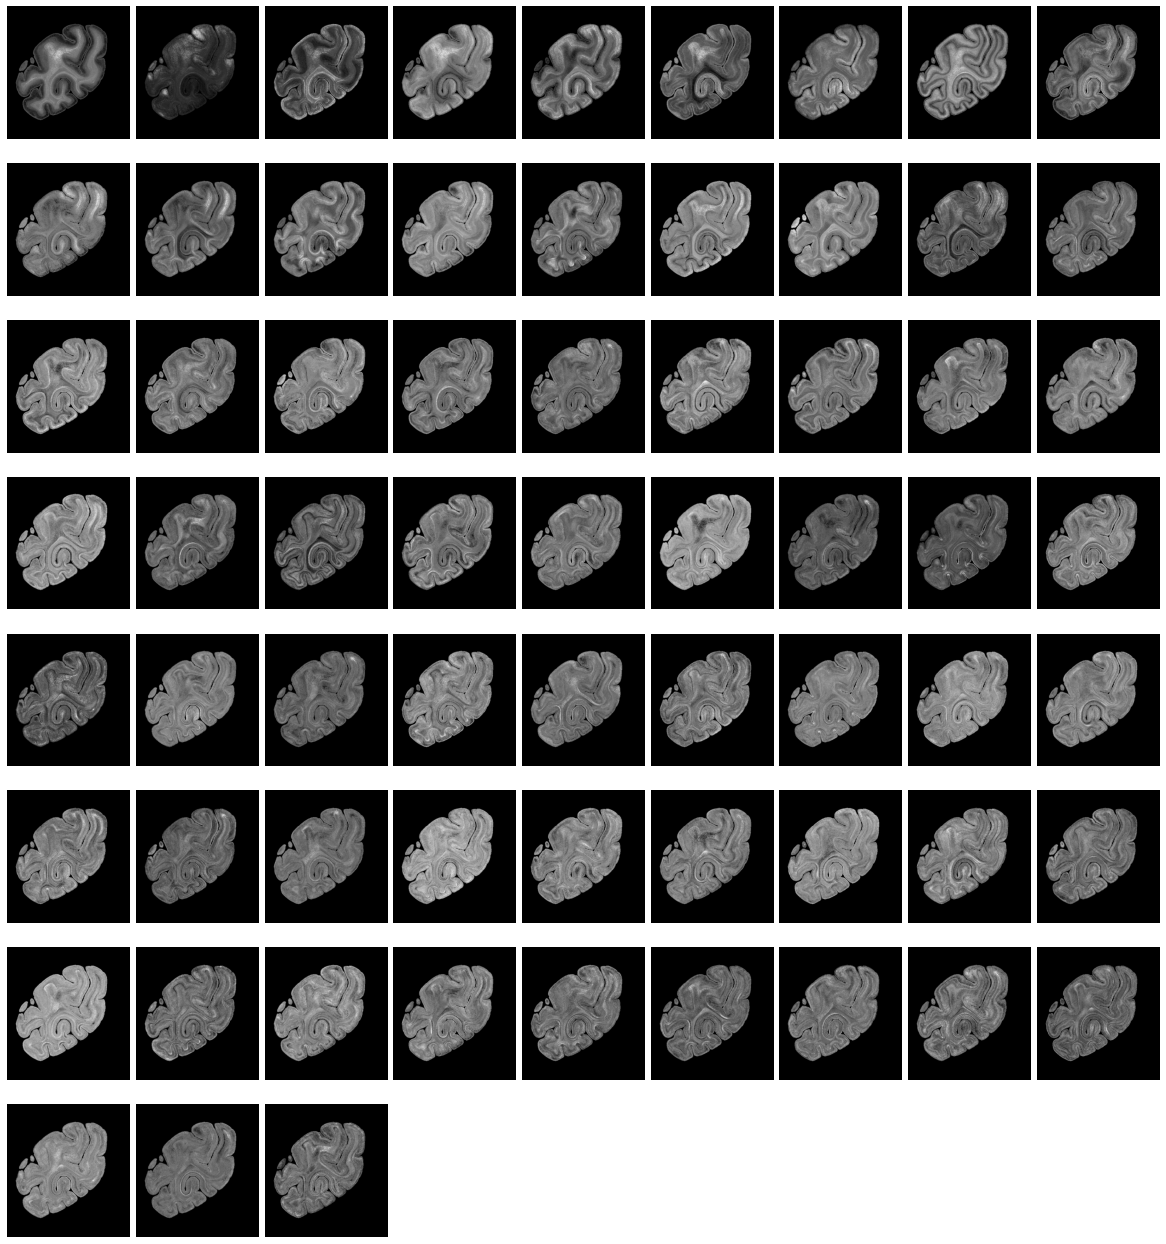

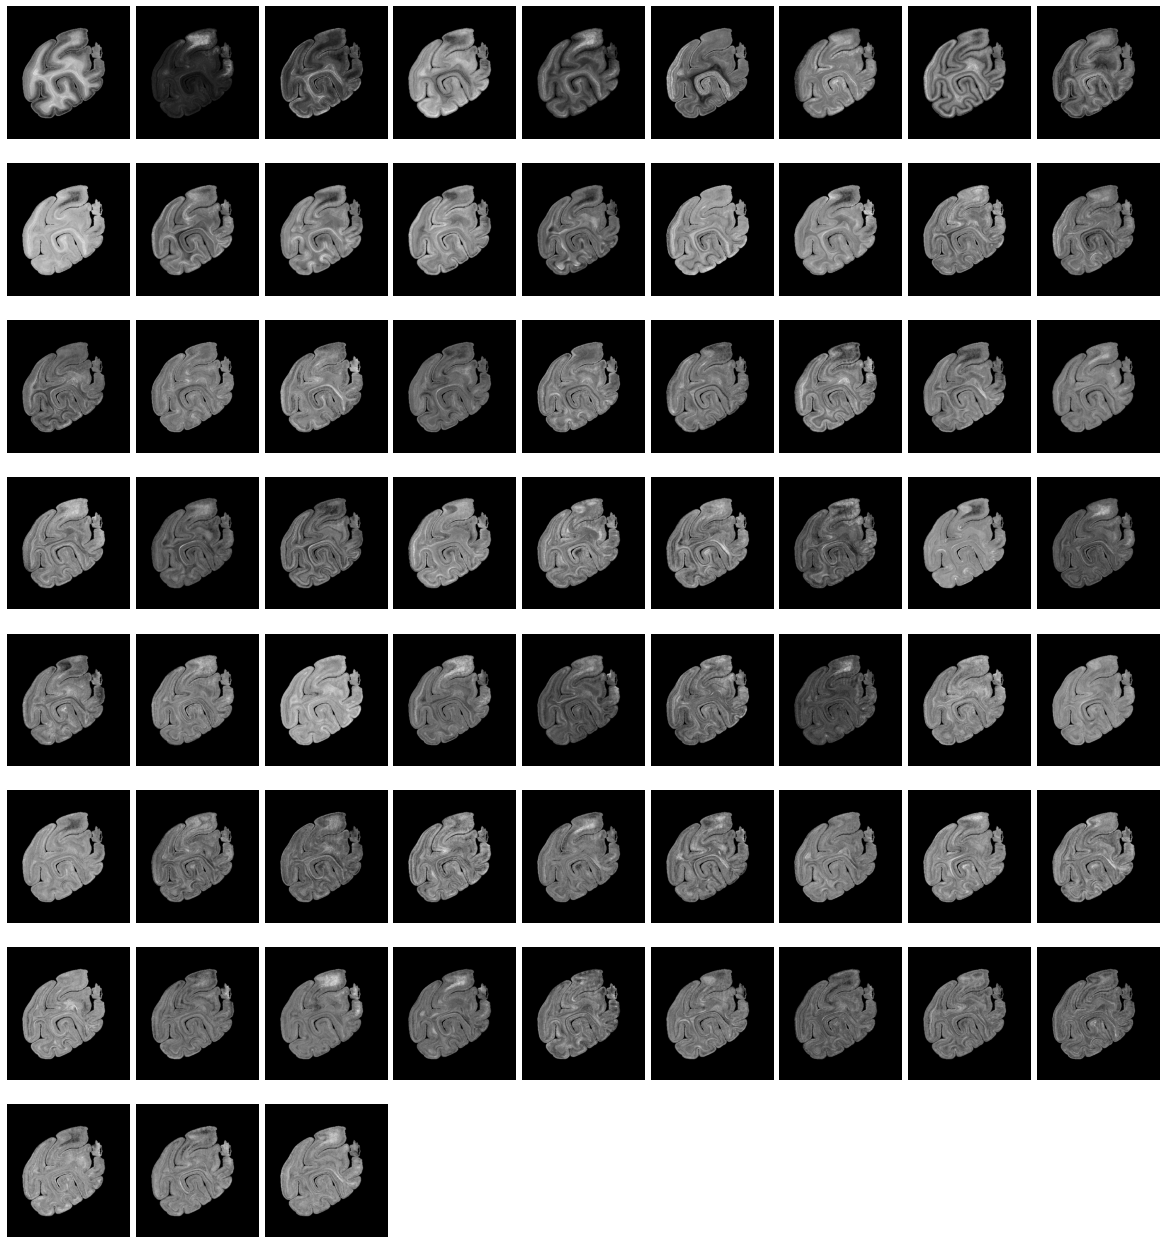

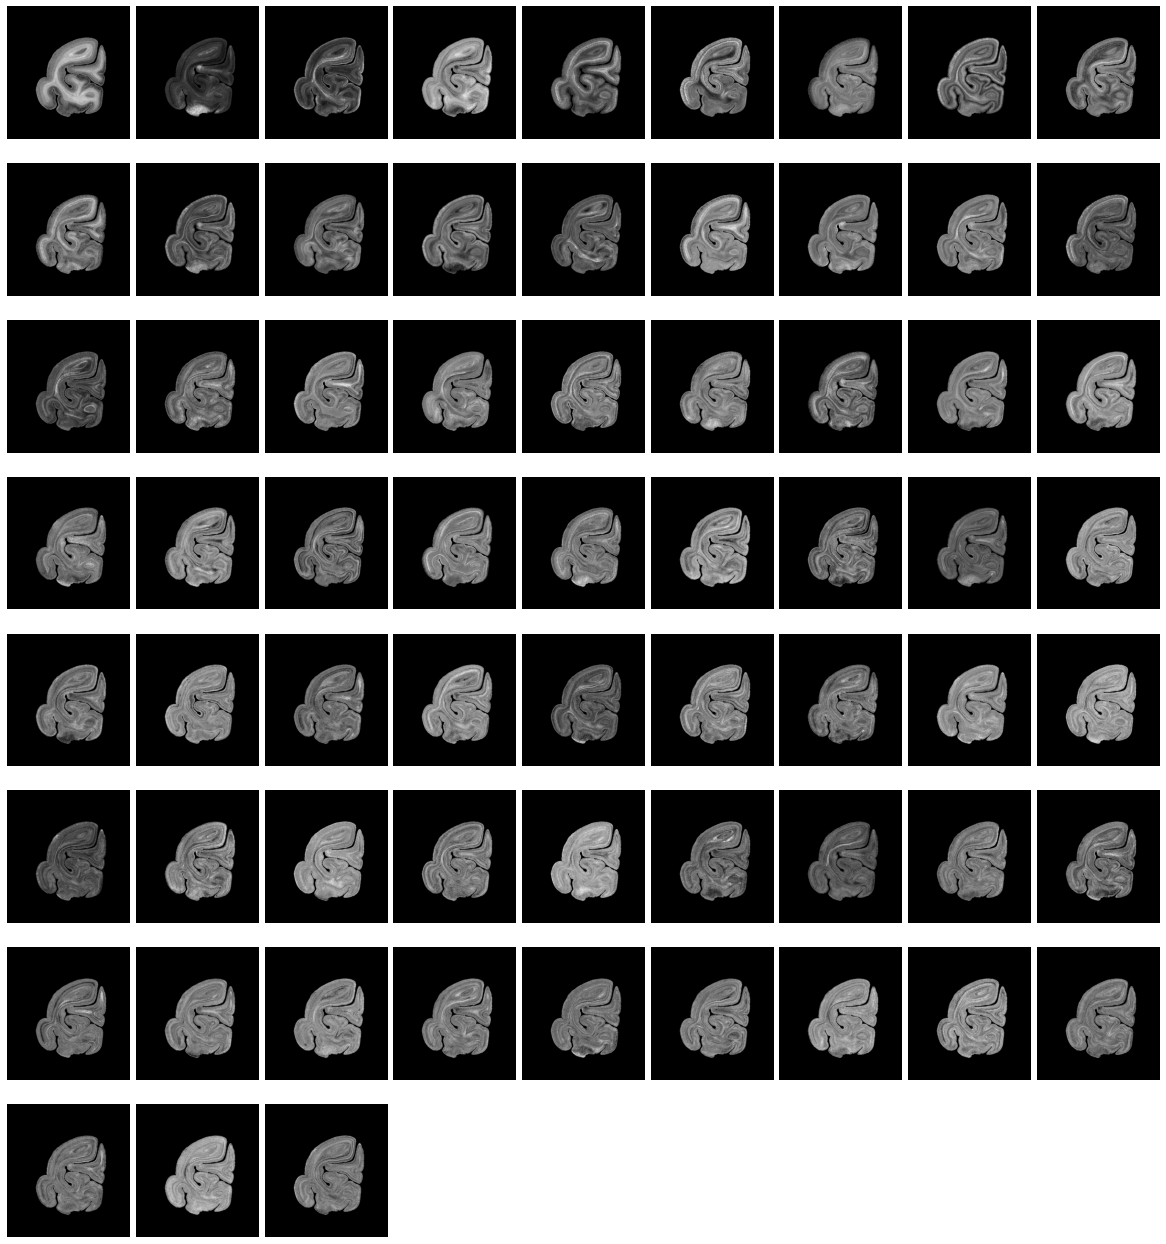

In [18]:
test_ids = [860, 898, 961, 1061]

###

out_path = os.path.join(out_folder, model_name, 'overview')

for test_id in test_ids:
    test_file = files_df.loc[files_df.id == test_id].iloc[0]

    test_features, test_mask = read_masked_features(
        test_file.file_feature,
        test_file.file_mask,
        mask_pyramid=mask_pyramid,
        data_group=data_group,
        mask_group=mask_group
    )

    test_features = np.rot90(test_features, 3)
    test_mask = np.rot90(test_mask, 3)

    test_tissue = test_mask != background_class

    test_valid = test_tissue
    test_std = scaler.transform(test_features.reshape(-1, test_features.shape[-1]))
    test_pca = pca.transform(test_std)
    test_pca = test_pca.reshape(*test_features.shape[:2], test_pca.shape[-1])

    print_pca = np.empty((*test_features.shape[:2], test_pca.shape[-1]), dtype=np.float16)
    for i in range(test_pca.shape[-1]):
        print_pca[..., i][test_valid] = test_pca[..., i][test_valid]
        print_pca[..., i][~test_valid] = np.min(test_pca[..., i])

    if not os.path.exists(out_path):
        os.mkdir(out_path)

    print_components = min(n_components, 16)

    im.show(np.stack([print_pca[..., i] for i in range(print_components)]), ch='NHW', size=16, file=out_path + f"/pca_{n_components}_s{test_id:04d}")